# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.253025,True,7.730459
1,0.829617,False,0.665477
2,-0.365939,True,5.507432
3,1.907286,False,1.179113
4,0.896438,True,7.636563
...,...,...,...
995,0.713612,True,6.358418
996,0.489737,True,4.386484
997,-0.054579,False,1.051083
998,-0.758831,False,0.219016


<AxesSubplot: xlabel='v0'>

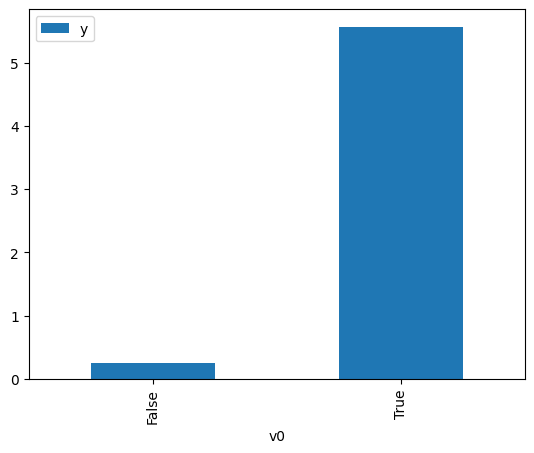

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

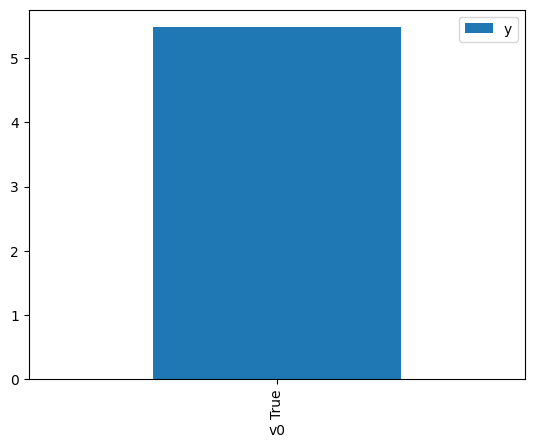

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.565599,False,-1.536105,0.674490,1.482603
1,0.803470,False,0.921438,0.247767,4.036051
2,-1.204674,False,0.312473,0.830201,1.204528
3,0.697675,False,0.115949,0.275192,3.633830
4,1.563104,False,0.088157,0.106120,9.423279
...,...,...,...,...,...
995,1.563104,False,0.088157,0.106120,9.423279
996,0.887526,False,2.034403,0.227326,4.398970
997,1.259145,False,0.120230,0.151526,6.599519
998,0.361272,False,-0.762479,0.373662,2.676214


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.745462,True,4.362752,0.274845,3.638413
1,1.549672,True,6.250553,0.892156,1.120880
2,0.058439,True,5.099115,0.527405,1.896075
3,1.464874,True,8.018346,0.880697,1.135465
4,-0.405352,True,5.173181,0.374421,2.670788
...,...,...,...,...,...
995,-0.092552,True,5.622993,0.476742,2.097571
996,-0.407226,True,3.774108,0.373832,2.674999
997,1.599512,True,5.420082,0.898431,1.113052
998,0.702576,True,6.032835,0.726119,1.377184


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.059e+04
Date:                Wed, 16 Nov 2022   Prob (F-statistic):                        0.00
Time:                        11:56:13   Log-Likelihood:                         -1419.0
No. Observations:                1000   AIC:                                      2842.
Df Residuals:                     998   BIC:                                      2852.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6423      0.036     17.793      0.000       0.571       0.713
x2             5.1138      0.052     99.049      0.000       5.013       5.215
==============================================================================
Omnibus:                        0.503   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.490
Skew:                           0.054   Prob(JB):                        0.783
Kurtosis:                       2.996   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""